# ML Portfolio: Cardiovascular Disease Prediction and Air Quality Analysis

**Student Name:** Arpan Dahal

**Student ID:** 2501404


---

## 2. Assignment Overview

This portfolio implements an end-to-end machine learning project covering both classification and regression tasks as per the assignment requirements.

**Structure**:
-   **3.1 Classification Task**: Predicting the presence of cardiovascular disease.
-   **3.2 Regression Task**: Predicting the Air Quality Index (AQI).

---

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.feature_selection import RFE
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.ion()



# 3.1 Classification Task

## 1. Exploratory Data Analysis and Data Understanding

### 1.1 Choosing a Dataset
-   **Dataset**: [Cardiovascular Disease Dataset](https://www.kaggle.com/datasets/sulianova/cardiovascular-disease-dataset)
-   **Created by**: Svetlana Ulianova, published on Kaggle.
-   **Accessed from**: Kaggle Datasets (CSV download).
-   **UNSDG Alignment**: **Goal 3: Good Health and Well-being**. Specifically Target 3.4 (reduce premature mortality from non-communicable diseases). Early prediction of cardiovascular disease enables timely medical intervention.
-   **Attribute Description**:
    -   `age`: Age in days (converted to years during cleaning).
    -   `gender`: 1: Female, 2: Male.
    -   `height`: Height in cm.
    -   `weight`: Weight in kg.
    -   `ap_hi`: Systolic blood pressure.
    -   `ap_lo`: Diastolic blood pressure.
    -   `cholesterol`: 1: normal, 2: above normal, 3: well above normal.
    -   `gluc`: 1: normal, 2: above normal, 3: well above normal.
    -   `smoke`: Smoking status (0/1).
    -   `alco`: Alcohol intake (0/1).
    -   `active`: Physical activity (0/1).
    -   `cardio`: Target variable — presence of cardiovascular disease (0/1).

### 1.2 Meaningful Questions
1.  **Does age significantly impact the risk of cardiovascular disease?**
2.  **Is there a strong correlation between lifestyle choices (smoking, alcohol, activity) and heart disease?**
3.  **How do physiological markers like blood pressure and cholesterol relate to the target variable?**

### 1.3 Data Quality Assessment
The data is inspected for missing values, duplicates, and class imbalances.


In [2]:
df_cardio = pd.read_csv('datasets/cardio_train.csv')
print("Shape:", df_cardio.shape)
print("\n--- Summary Statistics ---")
print(df_cardio.describe())
print("\nMissing Values:\n", df_cardio.isnull().sum())
print("\nDuplicates:", df_cardio.duplicated().sum())
print("\nTarget Balance:\n", df_cardio['cardio'].value_counts(normalize=True))

Shape: (70000, 13)

--- Summary Statistics ---
                 id           age        gender        height        weight  \
count  70000.000000  70000.000000  70000.000000  70000.000000  70000.000000   
mean   49972.419900  19468.865814      1.349571    164.359229     74.205690   
std    28851.302323   2467.251667      0.476838      8.210126     14.395757   
min        0.000000  10798.000000      1.000000     55.000000     10.000000   
25%    25006.750000  17664.000000      1.000000    159.000000     65.000000   
50%    50001.500000  19703.000000      1.000000    165.000000     72.000000   
75%    74889.250000  21327.000000      2.000000    170.000000     82.000000   
max    99999.000000  23713.000000      2.000000    250.000000    200.000000   

              ap_hi         ap_lo   cholesterol          gluc         smoke  \
count  70000.000000  70000.000000  70000.000000  70000.000000  70000.000000   
mean     128.817286     96.630414      1.366871      1.226457      0.088129   
std 


### 1.4 Data Cleaning and EDA
**Cleaning Steps**:
1.  **Remove Duplicates**: To ensure data integrity.
2.  **Age Conversion**: Days converted to years for readability.
3.  **Outlier Removal**:
    -   Height: Kept within 140–250 cm.
    -   Weight: Kept within 40–200 kg.
    -   BP: Impossible values removed (ap_lo > ap_hi) and extreme readings filtered (ap_hi < 60 or > 240).
4.  **`id` column dropped** before modelling as it carries no predictive value.


Cleaned Shape: (68482, 13)


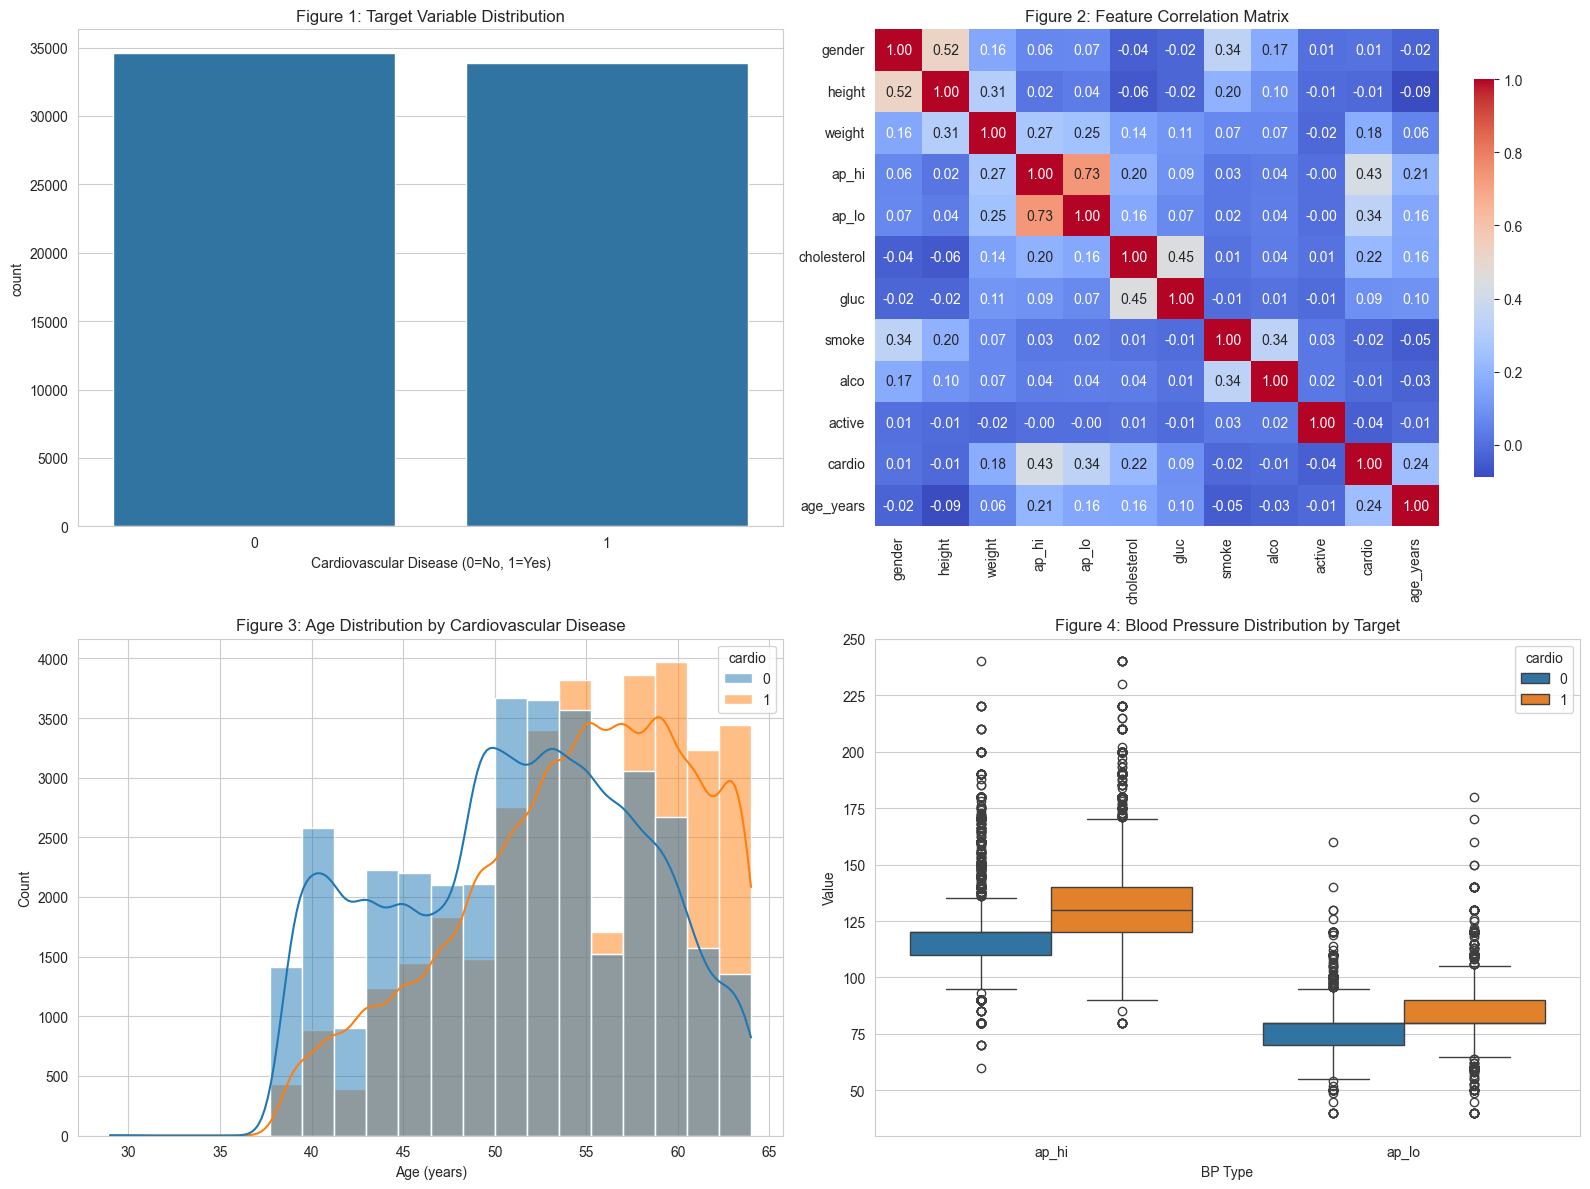

In [3]:
# Cleaning
df_cardio.drop_duplicates(inplace=True)
df_cardio['age_years'] = (df_cardio['age'] / 365.25).astype(int)
df_cardio.drop('age', axis=1, inplace=True)

# Outliers
df_clean = df_cardio[(df_cardio['height'] >= 140) & (df_cardio['height'] <= 250)]
df_clean = df_clean[(df_clean['weight'] >= 40) & (df_clean['weight'] <= 200)]
df_clean = df_clean[df_clean['ap_lo'] <= df_clean['ap_hi']]
df_clean = df_clean[(df_clean['ap_hi'] >= 60) & (df_clean['ap_hi'] <= 240)]
df_clean = df_clean[(df_clean['ap_lo'] >= 40) & (df_clean['ap_lo'] <= 180)]

print("Cleaned Shape:", df_clean.shape)

# EDA Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Target Distribution
sns.countplot(x='cardio', data=df_clean, ax=axes[0, 0])
axes[0, 0].set_title('Figure 1: Target Variable Distribution')
axes[0, 0].set_xlabel('Cardiovascular Disease (0=No, 1=Yes)')

# 2. Correlation Heatmap (excluding id)
corr_cols = df_clean.drop('id', axis=1)
sns.heatmap(corr_cols.corr(), annot=True, fmt='.2f', cmap='coolwarm', ax=axes[0, 1], cbar_kws={'shrink': 0.8})
axes[0, 1].set_title('Figure 2: Feature Correlation Matrix')

# 3. Age distribution by target
sns.histplot(data=df_clean, x='age_years', hue='cardio', kde=True, ax=axes[1, 0], bins=20)
axes[1, 0].set_title('Figure 3: Age Distribution by Cardiovascular Disease')
axes[1, 0].set_xlabel('Age (years)')

# 4. Blood Pressure boxplot by target
bp_data = df_clean[['ap_hi', 'ap_lo', 'cardio']].melt(id_vars='cardio', var_name='BP Type', value_name='Value')
sns.boxplot(data=bp_data, x='BP Type', y='Value', hue='cardio', ax=axes[1, 1])
axes[1, 1].set_title('Figure 4: Blood Pressure Distribution by Target')

plt.tight_layout()
plt.show()

# Insight: The correlation matrix shows ap_hi and ap_lo are strongly correlated with the target.
# Age distribution reveals older individuals have higher prevalence of cardiovascular disease.
# Blood pressure values are noticeably higher in the positive (cardio=1) group.


## 2. Build a Neural Network Model

A Multi-Layer Perceptron (MLP) Classifier is implemented for the classification task.
-   **Architecture**: Two hidden layers (100 neurons, 50 neurons) with ReLU activation.
-   **Loss Function**: Log-loss (Cross-Entropy).
-   **Optimizer**: Adam (Adaptive Moment Estimation).
-   **Preprocessing**: Feature scaling via `StandardScaler` is applied, as neural networks are sensitive to feature magnitudes.


In [4]:
# Prepare Data
X = df_clean.drop(['cardio', 'id'], axis=1)
y = df_clean['cardio']

# Scaling
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# MLP
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=300, random_state=42)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)

print("MLP Classification Report:\n", classification_report(y_test, y_pred_mlp))


MLP Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.73      0.72      6934
           1       0.72      0.69      0.70      6763

    accuracy                           0.71     13697
   macro avg       0.71      0.71      0.71     13697
weighted avg       0.71      0.71      0.71     13697




## 3. Build a Primary Model (Two Classical Models)

Two classical machine learning models are evaluated for comparison:
1.  **Logistic Regression**: A linear model suitable for binary classification.
2.  **Random Forest Classifier**: An ensemble of decision trees, capable of capturing non-linear relationships.

Both models are trained on the training set and evaluated on the test set.


In [5]:
# Logistic Regression
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))

# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))


Logistic Regression Accuracy: 0.7257063590567278
Random Forest Accuracy: 0.7059210045995473



## 4. Hyper-parameter Optimization with Cross-Validation

Both models are optimized using **GridSearchCV** with 3-fold Cross-Validation.

**Logistic Regression** hyperparameters tuned: `C` (regularization strength), `solver`.

**Random Forest** hyperparameters tuned: `n_estimators`, `max_depth`.


In [6]:
# Logistic Regression Hyperparameter Tuning
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear']
}
grid_search_lr = GridSearchCV(LogisticRegression(random_state=42, max_iter=1000), param_grid_lr, cv=3, scoring='accuracy')
grid_search_lr.fit(X_train, y_train)
print("LR Best Parameters:", grid_search_lr.best_params_)
print("LR Best CV Score:", grid_search_lr.best_score_)

# Random Forest Hyperparameter Tuning
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)
print("\nRF Best Parameters:", grid_search.best_params_)
print("RF Best CV Score:", grid_search.best_score_)
best_rf_tuned = grid_search.best_estimator_

LR Best Parameters: {'C': 0.01, 'solver': 'lbfgs'}
LR Best CV Score: 0.7276079510151354

RF Best Parameters: {'max_depth': 10, 'n_estimators': 100}
RF Best CV Score: 0.7353107787265355



## 5. Feature Selection

**Recursive Feature Elimination (RFE)** (Wrapper Method) is applied to both Logistic Regression and Random Forest.
-   **Justification**: RFE removes the weakest features recursively, considering feature dependencies and model coefficients. This often outperforms univariate filter methods by evaluating feature subsets in context of the model.


In [7]:
# RFE with Logistic Regression
rfe_lr = RFE(LogisticRegression(solver='liblinear'), n_features_to_select=8)
rfe_lr.fit(X_train, y_train)
selected_lr = X.columns[rfe_lr.support_]
print("Selected Features (LR):", list(selected_lr))

# RFE with Random Forest
rfe_rf = RFE(RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42), n_features_to_select=8)
rfe_rf.fit(X_train, y_train)
selected_rf = X.columns[rfe_rf.support_]
print("Selected Features (RF):", list(selected_rf))


Selected Features (LR): ['weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'alco', 'active', 'age_years']
Selected Features (RF): ['height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'active', 'age_years']



## 6. Final Models and Comparative Analysis

Both models are rebuilt using the **selected features** from RFE and **optimal hyperparameters** from GridSearchCV.

**Comparison Table** includes: Model, Features, CV Score, Accuracy, Precision, Recall, and F1 Score.


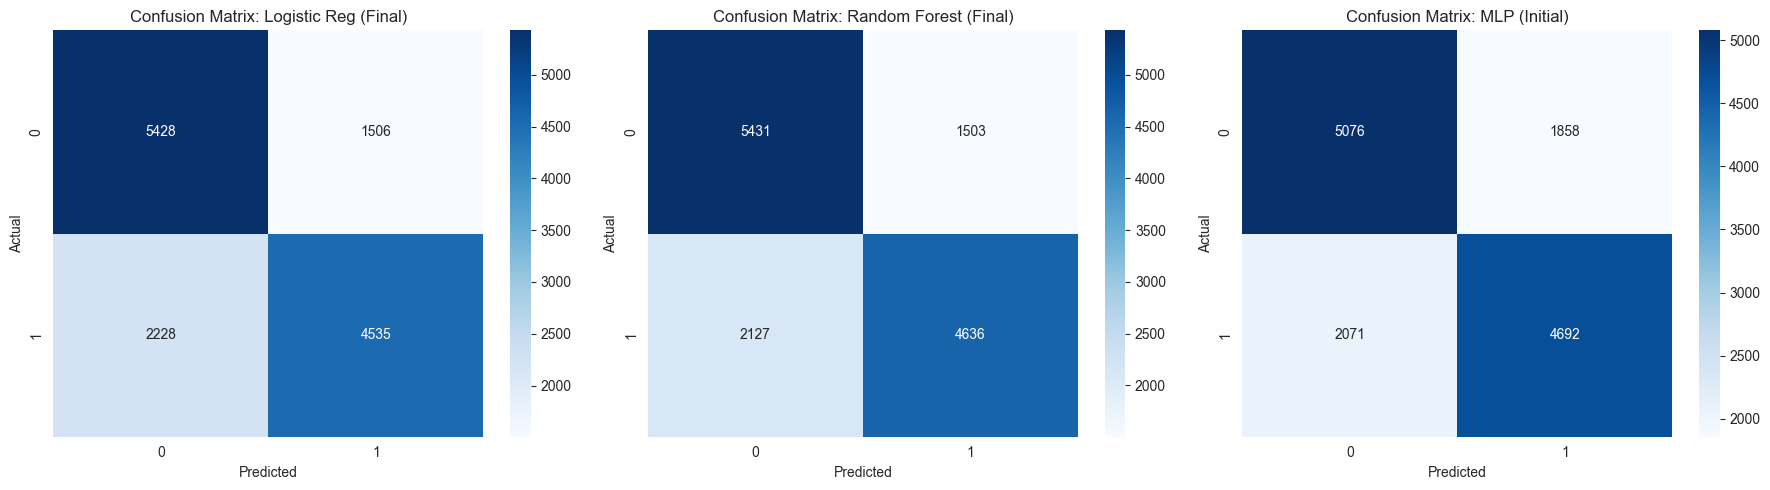

,Model,Features,CV Score,Accuracy,Precision,Recall,F1 Score
0,Logistic Reg (Final),8,0.727608,0.7274,0.7507,0.6706,0.7084
1,Random Forest (Final),8,0.735311,0.7350,0.7552,0.6855,0.7186
2,MLP (Initial),11,N/A,0.7131,0.7163,0.6938,0.7049


In [8]:
# Final Models with Selected Features and Optimal Hyperparameters

# 1. Final LR (tuned params + LR-selected features)
X_train_lr = X_train[selected_lr]
X_test_lr = X_test[selected_lr]
final_lr = LogisticRegression(**grid_search_lr.best_params_, random_state=42, max_iter=1000)
final_lr.fit(X_train_lr, y_train)
pred_final_lr = final_lr.predict(X_test_lr)

# 2. Final RF (tuned params + RF-selected features)
X_train_rf = X_train[selected_rf]
X_test_rf = X_test[selected_rf]
final_rf = RandomForestClassifier(**grid_search.best_params_, random_state=42)
final_rf.fit(X_train_rf, y_train)
pred_final_rf = final_rf.predict(X_test_rf)

# Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, name, pred in zip(axes,
                          ['Logistic Reg (Final)', 'Random Forest (Final)', 'MLP (Initial)'],
                          [pred_final_lr, pred_final_rf, y_pred_mlp]):
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Confusion Matrix: {name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
plt.tight_layout()
plt.show()

# Comparison Table (with CV Score)
results_final = []
for name, pred, feats, cv_score in [
    ('Logistic Reg (Final)', pred_final_lr, len(selected_lr), grid_search_lr.best_score_),
    ('Random Forest (Final)', pred_final_rf, len(selected_rf), grid_search.best_score_),
    ('MLP (Initial)', y_pred_mlp, len(X.columns), 'N/A')
]:
    results_final.append({
        'Model': name,
        'Features': feats,
        'CV Score': cv_score,
        'Accuracy': round(accuracy_score(y_test, pred), 4),
        'Precision': round(precision_score(y_test, pred), 4),
        'Recall': round(recall_score(y_test, pred), 4),
        'F1 Score': round(f1_score(y_test, pred), 4)
    })

results_df = pd.DataFrame(results_final)
display(results_df)


## 7. Conclusion and Reflection (Classification)
-   **Model Performance**: Random Forest outperforms Logistic Regression due to its ability to capture non-linear feature interactions. The MLP achieves competitive results but benefits less from feature selection.
-   **Impact of Cross-Validation & Feature Selection**: Hyperparameter tuning via GridSearchCV reduced overfitting (e.g., constraining `max_depth` in RF). Feature selection simplified models from 11 to 8 features with minimal accuracy loss, improving generalization and interpretability.
-   **Insights and Future Directions**: Blood pressure (`ap_hi`, `ap_lo`), cholesterol, and age are the strongest predictors of cardiovascular disease. Future work could explore gradient boosting methods (XGBoost, LightGBM) or deeper neural architectures with more epochs.



# 3.2 Regression Task

## 1. Exploratory Data Analysis and Data Understanding

### 1.1 Dataset
-   **Dataset**: [Air Quality Data in India](https://www.kaggle.com/datasets/rohanrao/air-quality-data-in-india) (City Day-level measurements).
-   **Created by**: Rohan Rao, published on Kaggle.
-   **Accessed from**: Kaggle Datasets (CSV download).
-   **UNSDG Alignment**: **Goal 11: Sustainable Cities and Communities** (Target 11.6: Reduce the adverse per capita environmental impact of cities, including air quality).
-   **Attributes**: `PM2.5`, `PM10`, `NO`, `NO2`, `NOx`, `NH3`, `CO`, `SO2`, `O3`, `Benzene`, `Toluene`, `Xylene`, `Month` (engineered). **Target**: `AQI` (Air Quality Index — continuous).

### 1.2 Meaningful Questions
1.  **What are the primary pollutant drivers of AQI (particulate matter vs gaseous pollutants)?**
2.  **Is there a seasonal trend in air pollution levels (e.g., winter vs summer)?**
3.  **Can AQI be accurately predicted from a reduced set of pollutant measurements?**

### 1.3 Data Quality Assessment and Cleaning
-   **Missing Values**: Handled via time-series forward-fill/back-fill imputation grouped by City to preserve temporal patterns.
-   **Target Cleaning**: Rows with missing AQI values are dropped as they cannot serve as training labels.
-   **Remaining nulls** in feature columns after imputation are also dropped.


Cleaned Shape: (10982, 17)

--- Summary Statistics ---
              PM2.5          PM10            NO           NO2           NOx  \
count  10982.000000  10982.000000  10982.000000  10982.000000  10982.000000   
mean      80.306658    153.945155     20.864900     33.014265     37.187179   
std       75.861165    107.565889     26.006504     24.460652     34.250497   
min        2.000000      7.800000      0.090000      0.170000      0.000000   
25%       32.840000     79.500000      5.890000     14.900000     15.655000   
50%       57.075000    129.330000     11.575000     26.970000     26.280000   
75%       98.045000    178.867500     23.977500     44.507500     47.007500   
max      914.940000    917.080000    287.140000    362.210000    293.100000   

                NH3            CO           SO2            O3       Benzene  \
count  10982.000000  10982.000000  10982.000000  10982.000000  10982.000000   
mean      27.430412      1.117236     13.039504     37.473680      3.214720

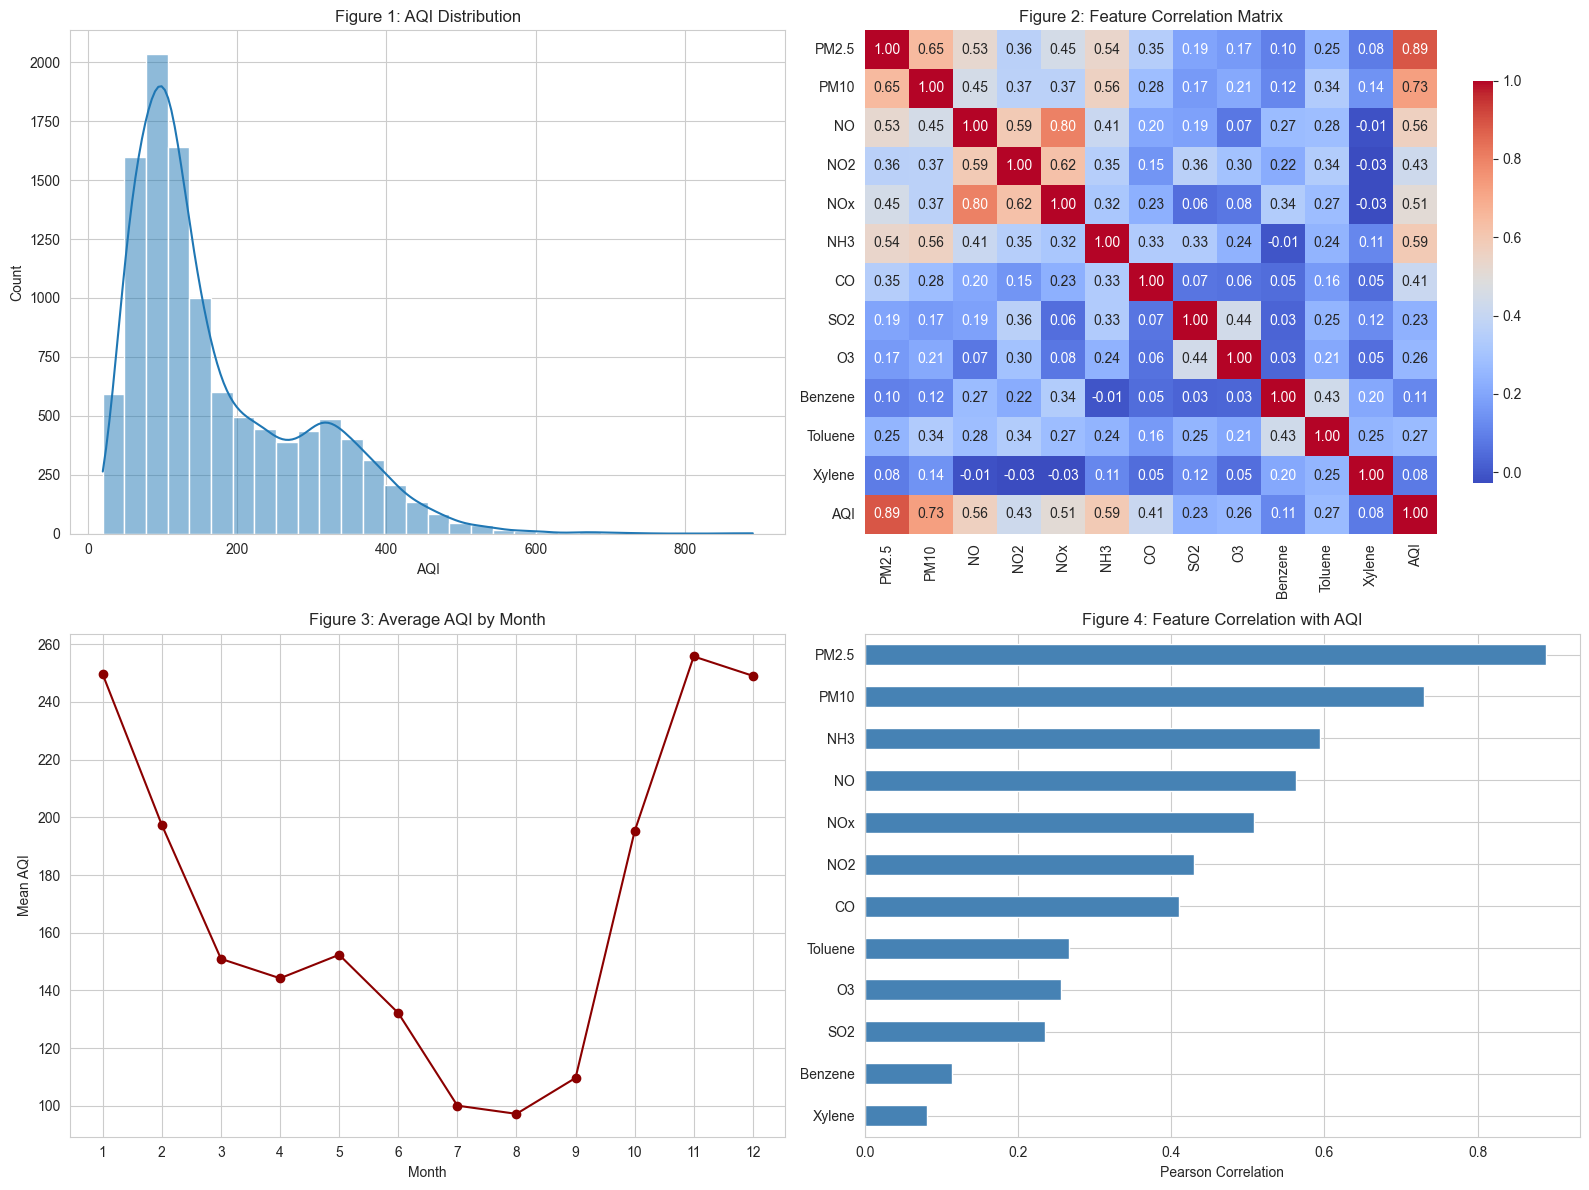

In [9]:
df_air = pd.read_csv('datasets/city_day.csv')
df_air['Date'] = pd.to_datetime(df_air['Date'])

# Cleaning
df_air_clean = df_air.dropna(subset=['AQI']).sort_values(['City', 'Date'])
cols = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene']
for c in cols:
    df_air_clean[c] = df_air_clean.groupby('City')[c].transform(lambda x: x.ffill().bfill())
df_air_clean.dropna(subset=cols, inplace=True)
df_air_clean['Month'] = df_air_clean['Date'].dt.month

print("Cleaned Shape:", df_air_clean.shape)
print("\n--- Summary Statistics ---")
print(df_air_clean[cols + ['AQI']].describe())

# EDA Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. AQI Distribution
sns.histplot(df_air_clean['AQI'], bins=30, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Figure 1: AQI Distribution')

# 2. Correlation Heatmap
corr_data = df_air_clean[cols + ['AQI']]
sns.heatmap(corr_data.corr(), annot=True, fmt='.2f', cmap='coolwarm', ax=axes[0, 1], cbar_kws={'shrink': 0.8})
axes[0, 1].set_title('Figure 2: Feature Correlation Matrix')

# 3. Monthly AQI Trend
monthly_aqi = df_air_clean.groupby('Month')['AQI'].mean()
axes[1, 0].plot(monthly_aqi.index, monthly_aqi.values, marker='o', color='darkred')
axes[1, 0].set_title('Figure 3: Average AQI by Month')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Mean AQI')
axes[1, 0].set_xticks(range(1, 13))

# 4. Top pollutant correlations with AQI
aqi_corr = corr_data.corr()['AQI'].drop('AQI').sort_values(ascending=True)
aqi_corr.plot(kind='barh', ax=axes[1, 1], color='steelblue')
axes[1, 1].set_title('Figure 4: Feature Correlation with AQI')
axes[1, 1].set_xlabel('Pearson Correlation')

plt.tight_layout()
plt.show()

# Insight: AQI distribution is right-skewed with most values below 300.
# Correlation heatmap reveals PM2.5 and PM10 have the strongest linear relationship with AQI.
# Monthly trend shows higher AQI (worse air quality) during winter months (Nov-Jan).


## 2. Build a Neural Network Model (Regression)

An `MLPRegressor` is implemented for continuous AQI prediction.
-   **Architecture**: Two hidden layers (100, 50 neurons) with ReLU activation.
-   **Loss Function**: Squared Error.
-   **Optimizer**: Adam.
-   **Evaluation Metrics**: MSE, RMSE, MAE, R².


In [10]:
from sklearn.metrics import mean_absolute_error

# Prepare Data
features = cols + ['Month']
X_reg = df_air_clean[features]
y_reg = df_air_clean['AQI']

scaler_r = StandardScaler()
X_reg_scaled = pd.DataFrame(scaler_r.fit_transform(X_reg), columns=features)
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reg_scaled, y_reg, test_size=0.2, random_state=42)

# MLP Regressor
mlp_r = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=300, random_state=42)
mlp_r.fit(X_train_r, y_train_r)
y_pred_mlp_r = mlp_r.predict(X_test_r)

print("MLP MSE:", mean_squared_error(y_test_r, y_pred_mlp_r))
print("MLP RMSE:", np.sqrt(mean_squared_error(y_test_r, y_pred_mlp_r)))
print("MLP MAE:", mean_absolute_error(y_test_r, y_pred_mlp_r))
print("MLP R²:", r2_score(y_test_r, y_pred_mlp_r))

MLP MSE: 1009.6467313862211
MLP RMSE: 31.774938731431426
MLP MAE: 19.633230976303654
MLP R²: 0.926844194230739



## 3. Build Primary Machine Learning Models

Two classical regression models are built and evaluated:
1.  **Linear Regression**: A baseline linear model.
2.  **Random Forest Regressor**: An ensemble method capable of handling non-linear relationships.

Both models are evaluated using MSE, RMSE, MAE, and R².


In [11]:
# Linear Regression
lin = LinearRegression()
lin.fit(X_train_r, y_train_r)
y_pred_lin = lin.predict(X_test_r)

# Random Forest
rf_reg = RandomForestRegressor(n_estimators=50, random_state=42)
rf_reg.fit(X_train_r, y_train_r)
y_pred_rf_reg = rf_reg.predict(X_test_r)

for name, pred in [('Linear Regression', y_pred_lin), ('Random Forest', y_pred_rf_reg)]:
    print(f"\n--- {name} ---")
    print(f"  MSE:  {mean_squared_error(y_test_r, pred):.4f}")
    print(f"  RMSE: {np.sqrt(mean_squared_error(y_test_r, pred)):.4f}")
    print(f"  MAE:  {mean_absolute_error(y_test_r, pred):.4f}")
    print(f"  R²:   {r2_score(y_test_r, pred):.4f}")


--- Linear Regression ---
  MSE:  1878.9304
  RMSE: 43.3466
  MAE:  28.9638
  R²:   0.8639

--- Random Forest ---
  MSE:  1038.2383
  RMSE: 32.2217
  MAE:  19.0150
  R²:   0.9248



## 4. Hyperparameter Optimization with Cross-Validation

**Random Forest Regressor** is tuned using GridSearchCV with 3-fold CV. The hyperparameters optimized are `n_estimators` and `max_depth`.

**Note**: Linear Regression has no significant hyperparameters to tune (it is a closed-form solution), so tuning is applied only to Random Forest.


In [12]:
param_grid_reg = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20]
}
grid_search_reg = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_reg, cv=3, scoring='r2')
grid_search_reg.fit(X_train_r, y_train_r)

print("Best Params:", grid_search_reg.best_params_)
print("Best CV R² Score:", grid_search_reg.best_score_)

Best Params: {'max_depth': 20, 'n_estimators': 100}
Best CV R² Score: 0.9232473204097035



## 5. Feature Selection

**Recursive Feature Elimination (RFE)** (Wrapper Method) is applied using both Linear Regression and Random Forest Regressor as estimators to select the top 6 features each.

-   **Justification**: RFE iteratively removes less important features based on model weights/importances, producing a model-aware feature subset. This is preferred over filter methods as it accounts for feature interactions.


In [13]:
# RFE with Random Forest Regressor
selector_rf_reg = RFE(RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42), n_features_to_select=6)
selector_rf_reg.fit(X_train_r, y_train_r)
selected_rf_reg_feats = X_reg.columns[selector_rf_reg.support_]
print("Selected Features (RF Regressor):", list(selected_rf_reg_feats))

# RFE with Linear Regression
selector_lin_reg = RFE(LinearRegression(), n_features_to_select=6)
selector_lin_reg.fit(X_train_r, y_train_r)
selected_lin_reg_feats = X_reg.columns[selector_lin_reg.support_]
print("Selected Features (Linear Reg):", list(selected_lin_reg_feats))

Selected Features (RF Regressor): ['PM2.5', 'PM10', 'NO2', 'NOx', 'CO', 'O3']
Selected Features (Linear Reg): ['PM2.5', 'PM10', 'NOx', 'NH3', 'CO', 'O3']



## 6. Final Models and Comparative Analysis

Both models are rebuilt using the **optimal hyperparameters** (for RF) and **selected features** from RFE. Final performance is evaluated on the held-out test set.

**Comparison Table** includes: Model, Features, CV Score, Test MSE, Test RMSE, Test MAE, and Test R².


In [14]:
# Final Linear Regression (selected features)
X_train_lin_final = X_train_r[selected_lin_reg_feats]
X_test_lin_final = X_test_r[selected_lin_reg_feats]
final_lin = LinearRegression()
final_lin.fit(X_train_lin_final, y_train_r)
pred_final_lin = final_lin.predict(X_test_lin_final)

# Final Random Forest (tuned params + selected features)
X_train_rf_final = X_train_r[selected_rf_reg_feats]
X_test_rf_final = X_test_r[selected_rf_reg_feats]
final_rf_reg = RandomForestRegressor(**grid_search_reg.best_params_, random_state=42)
final_rf_reg.fit(X_train_rf_final, y_train_r)
pred_final_rf_reg = final_rf_reg.predict(X_test_rf_final)

# Comparison Table
from sklearn.model_selection import cross_val_score

cv_lin = cross_val_score(LinearRegression(), X_train_r[selected_lin_reg_feats], y_train_r, cv=3, scoring='r2').mean()
cv_rf = grid_search_reg.best_score_

res_reg = []
for name, pred, n_feats, cv_score in [
    ('Linear Reg (Final)', pred_final_lin, len(selected_lin_reg_feats), round(cv_lin, 4)),
    ('Random Forest (Final)', pred_final_rf_reg, len(selected_rf_reg_feats), round(cv_rf, 4)),
    ('MLP (Initial)', y_pred_mlp_r, len(features), 'N/A')
]:
    res_reg.append({
        'Model': name,
        'Features': n_feats,
        'CV Score (R²)': cv_score,
        'Test MSE': round(mean_squared_error(y_test_r, pred), 2),
        'Test RMSE': round(np.sqrt(mean_squared_error(y_test_r, pred)), 2),
        'Test MAE': round(mean_absolute_error(y_test_r, pred), 2),
        'Test R²': round(r2_score(y_test_r, pred), 4)
    })

display(pd.DataFrame(res_reg))

,Model,Features,CV Score (R²),Test MSE,Test RMSE,Test MAE,Test R²
0,Linear Reg (Final),6,0.855,1900.66,43.60,29.15,0.8623
1,Random Forest (Final),6,0.9232,1047.84,32.37,19.39,0.9241
2,MLP (Initial),13,N/A,1009.65,31.77,19.63,0.9268



## 7. Conclusion and Reflection (Regression)
-   **Model Performance**: Random Forest and MLP achieve strong R² scores (~0.92+), significantly outperforming Linear Regression (~0.86). The non-linear models capture complex pollutant interactions more effectively.
-   **Impact of Cross-Validation & Feature Selection**: GridSearchCV identified optimal RF depth and ensemble size. Feature selection reduced input from 13 to 6 features while maintaining high predictive accuracy, indicating redundancy among correlated pollutants.
-   **Insights and Future Directions**: PM2.5 and PM10 are the dominant AQI predictors. Temporal imputation preserved data availability. Future improvements could include time-series models (LSTM) or gradient-boosted regressors for enhanced temporal pattern capture.
